In [35]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

from scipy import signal
from scipy.special import sph_harm
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import scri

from math import pi

from matplotlib import rc
from spherical_functions import LM_index as lm

#rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Functions for reading in waveforms, and ramp function for tapering

In [2]:
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def ReadExtrapolatedModes(file, modes, theta, phi, order = 2, mass = 68 * const.M_sun, distance = 400000 * const.kpc, dt=1/2048):
    """ Read in an extrapolated SXS-format gravitational waveform mode, and 
        output the waveform in astrophysical units"""

    f = h5py.File(file, 'r')
    
    ## Grab the time axis -- the same for all modes
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l2_m2.dat']
    time = data[:,0]
    time = time - time[0]

    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))
    
    for mode in modes:
        
        l = mode[0]
        m = mode[1]
        data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
        
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        
        coef = data[:,1] + 1j * data[:,2]
        h = coef * Ylm
 
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
    
    plus_adj = h_plus*const.G*mass/((const.c)**2*distance)
    cross_adj = h_cross*const.G*mass/((const.c)**2*distance)
    time_adj = time*mass*const.G/(const.c**3)
    
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_plus = CubicSpline(time_adj,plus_adj)
    cs_cross = CubicSpline(time_adj,cross_adj)
    
    plus = cs_plus(times)
    cross = cs_cross(times)
    
    return times, plus, cross, dt

def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    

## Plot various modes

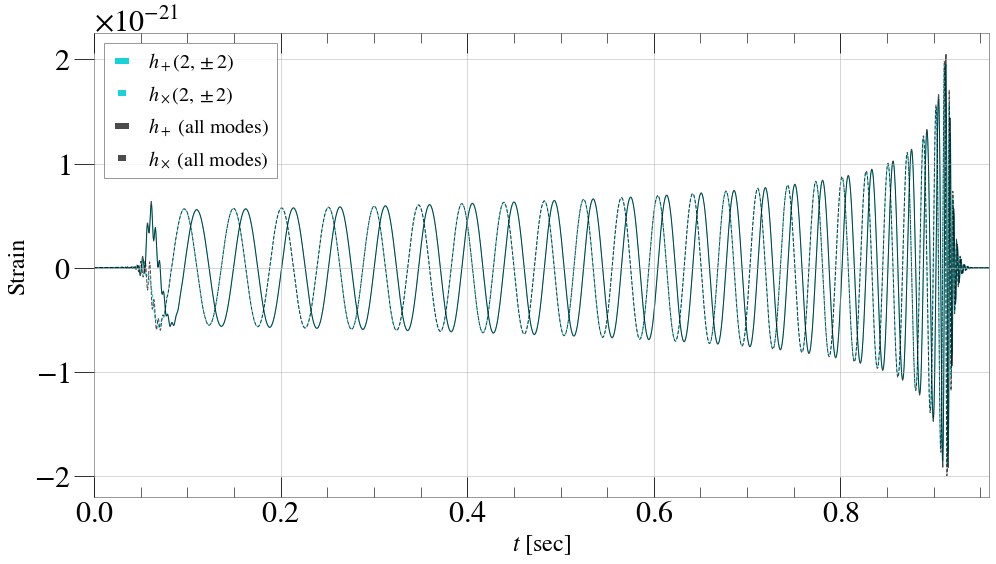

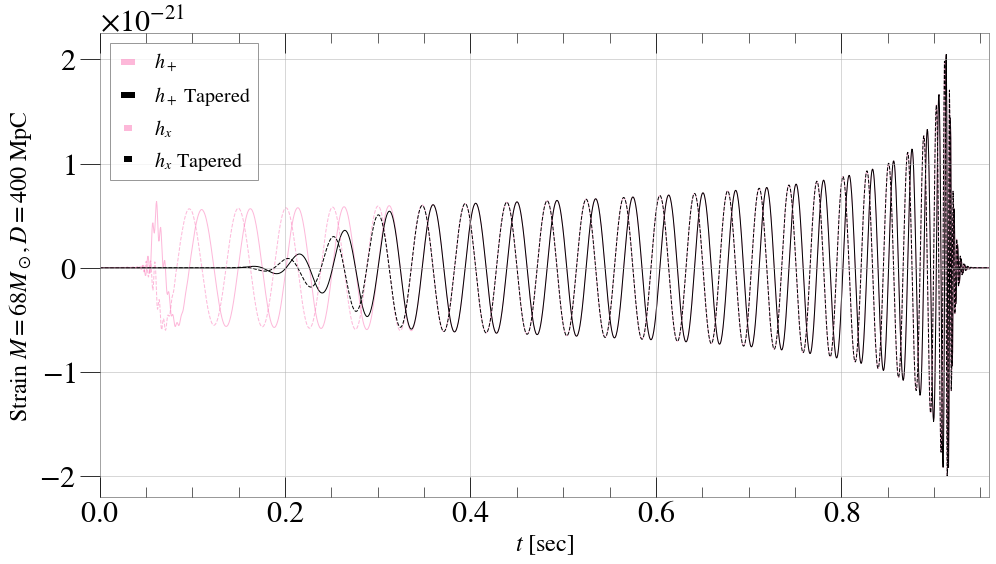

In [22]:
rh_file = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_0p0_Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"

theta = pi
phi = 0

## Modes figure

plt.figure(figsize=(14, 8))

#t_22, plus_22, cross_22, dt = ReadExtrapolatedModes(rh_file, [(2,2), (2,-2)], theta, phi, order = 2,  mass = 68 * const.M_sun)
plt.plot(t_22, plus_22, color='#18d2d9', label=r'$h_+ (2,\pm 2)$', lw = 1.0)
plt.plot(t_22, cross_22, color='#18d2d9', label=r'$h_\times (2,\pm 2)$', ls = '--', lw = 1.0)

all_modes = [[l,m] for l in range(2,9) for m in range(-l,l+1)]
#t, plus, cross, dt = ReadExtrapolatedModes(rh_file, all_modes, theta, phi, order = 2,  mass = 68 * const.M_sun)
plt.plot(t, plus, color='black', label=r'$h_+ $ (all modes)', lw = 1.0, ls = '-', alpha=0.7)
plt.plot(t, cross, color='black', label=r'$h_\times$ (all modes)', lw = 1.0, ls = '--', alpha=0.7)

plt.legend(ncol=1, fontsize=20)
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'Strain $M = 68 M_\odot, D = 400$ Mpc')
plt.xlim(min(t), max(t))
plt.tight_layout()

## Ramp figure

plt.figure(figsize=(14, 8))

ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])
plus_ramp = plus * ramp
cross_ramp = cross * ramp

plt.plot(t, plus, '-', lw=1.0, color='#fc72b5', label=r'$h_+$', alpha=0.5, ls='-')
plt.plot(t, plus * ramp, lw=1.0, color='black', label=r'$h_+$ Tapered', ls = '-')

plt.plot(t, cross, '-', lw=1.0, color='#fc72b5', label=r'$h_x$', alpha=0.5, ls='--')
plt.plot(t, cross * ramp, lw=1.0, color='black', label=r'$h_x$ Tapered', ls='--')

plt.xlim(min(t), max(t))
plt.legend(ncol=1, fontsize=20)
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'Strain $M = 68 M_\odot, D = 400$ Mpc')
plt.tight_layout()
plt.show()



## Compute h_plus and h_cross, shift data to desired gps time

In [24]:
## Compute and shift h_plus and h_cross
t_gps = 1126259462.4107006 ## desired gps time
peak_time_in_segment = 8.0 ## how late in the segment do we want the peak to occur?
segment_length = 16.0 ## how long do we want the segment to be?
sample_rate = 2048

## shift and pad the waveform before we do anything else
t_peak = t[np.argmax(plus_ramp**2 + cross_ramp**2)]

## want the peak time to correspond to 6 seconds
shift_amount = (peak_time_in_segment - t_peak)
start_pad = int(shift_amount * 2048)
end_pad = int(sample_rate*segment_length - len(plus_ramp) - start_pad)

plus_ramp_shift = np.pad(plus_ramp, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
cross_ramp_shift = np.pad(cross_ramp, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
t = np.arange(0., segment_length, dt) + t_gps - peak_time_in_segment


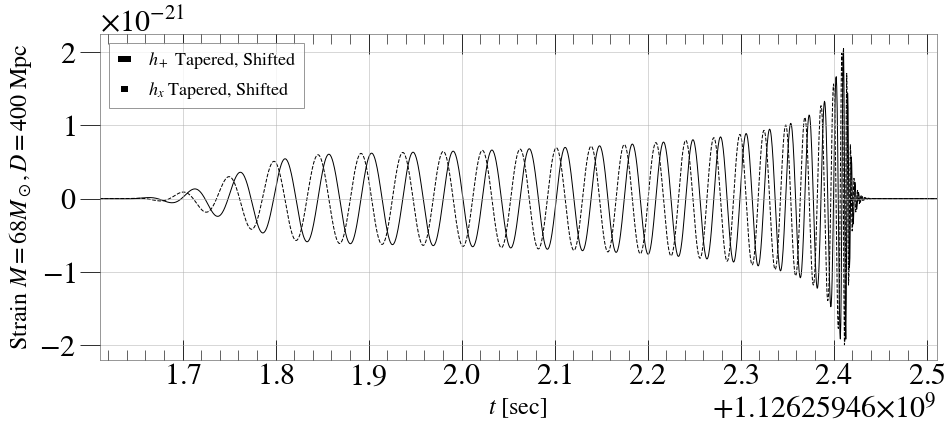

t_peak =  1126259462.4107006


In [30]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, plus_ramp_shift, label = r'$h_+$ Tapered, Shifted', color = 'black', ls = '-', lw = 1.0)
plt.plot(t, cross_ramp_shift, label = r'$h_x$ Tapered, Shifted', color = 'black', ls = '--', lw = 1.0)
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'Strain $M = 68 M_\odot, D = 400$ Mpc')
plt.legend()
plt.xlim(t_gps - 0.8, t_gps + 0.1)
plt.show()

print("t_peak = ",t[np.argmax(plus_ramp_shift**2 + cross_ramp_shift**2)])

## Project data to detectors

In [28]:
d_H1 = Detector("H1")
d_L1 = Detector("L1")

In [31]:
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1

0.005239059443450027


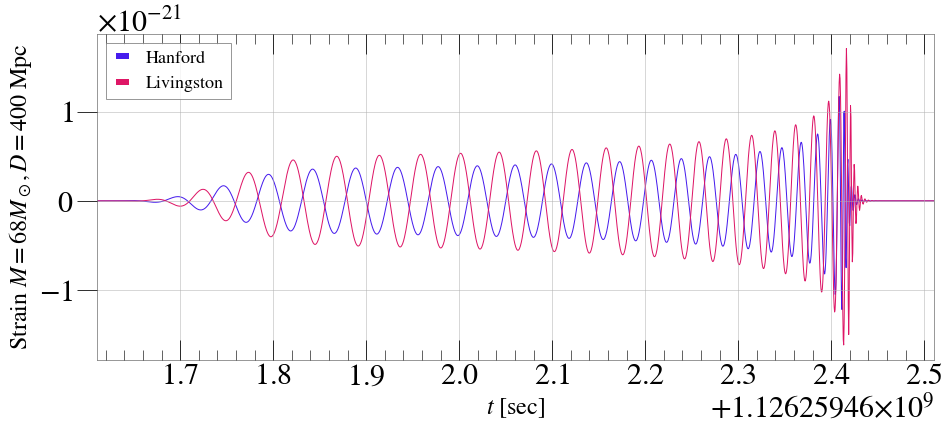

In [36]:
strainH, strainL, timeH, timeL = ProjectToDetectors(ra=4.7614763656, dec=-0.531780006467, pol=0.310886773011, \
                                                    t0=t_gps, plus=plus_ramp_shift, cross=cross_ramp_shift, time=t)

plt.figure(figsize = ([15, 6]))
plt.plot(timeH, strainH, label = "Hanford", color='#461ced', lw=1.0)
plt.plot(timeL, strainL, label = "Livingston", color='#de1666', lw=1.0)
plt.xlim(t_gps - 0.8, t_gps + 0.1)
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'Strain $M = 68 M_\odot, D = 400$ Mpc')
plt.legend(loc = 2)
plt.show()